In [49]:
import pandas as pd
import geopandas as gpd
from climada.hazard.tc_tracks import TCTracks
from climada.entity.exposures import base
from shapely.geometry import box, LineString
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

In [2]:
# Read in geoboundaries
filename = "/home/turnerm/Downloads/phl_adminboundaries_candidate_exclude_adm3.zip"
gdf = gpd.read_file(f"zip://{filename}!phl_admbnda_adm0_3part_psa_namria_itos_20200529.shp")
gdf1 = gpd.read_file(f"zip://{filename}!phl_admbnda_adm1_psa_namria_20200529.shp")
gdf2 = gpd.read_file(f"zip://{filename}!phl_admbnda_adm2_psa_namria_20200529.shp")

In [3]:
# Select adm1 of interest
gdf1 = gdf1[gdf1["ADM1_EN"].isin(["Region V", "Region VIII", "Region XIII"])]
gdf2 = gdf2[gdf2["ADM1_EN"].isin(["Region V", "Region VIII", "Region XIII"])]


In [4]:

scenario1 = [
    "Catanduanes", 
    "Camarines Norte", 
    "Camarines Sur", 
    "Albay", 
    "Sorsogon", 
    "Masbate",
    "Northern Samar",
    "Eastern Samar", 
    "Samar", 
    "Biliran"]
scenario2 = [
    "Leyte",
    "Southern Leyte",
    "Dinagat Islands",
    "Surigao del Norte",
    "Surigao del Sur",
    "Agusan del Norte",
    "Agusan del Sur"
]
gdf_s1 = gdf2[gdf2["ADM2_EN"].isin(scenario1)]
gdf_s2 = gdf2[gdf2["ADM2_EN"].isin(scenario2)]

In [22]:
# Create an exposure (needed later for tctracks)
exposure = base.Exposures(gpd.GeoDataFrame(geometry=[box(*gdf.total_bounds)], crs=gdf.crs))

In [6]:
# Get IBTracs
tc_tracks = TCTracks()
tc_tracks.read_ibtracs_netcdf()

2022-08-19 12:02:37,732 - climada.hazard.tc_tracks - WARNING - 6913 storm events are discarded because no valid wind/pressure values have been found: 1842298N11080, 1845336N10074, 1848011S09079, 1848011S09080, 1848011S15057, ...
2022-08-19 12:02:37,793 - climada.hazard.tc_tracks - WARNING - 326 storm events are discarded because only one valid timestep has been found: 1852232N21293, 1853242N12336, 1853245N34311, 1853270N14327, 1853291N32280, ...


In [25]:
tc_tracks_par = tc_tracks.tracks_in_exp(exposure, buffer=0.1)

/home/turnerm/sync/Typhoon-Impact-based-forecasting-model/venv/lib/python3.8/site-packages/climada/hazard/tc_tracks.py:294: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_buffer = exposure.gdf.buffer(distance=buffer, resolution=0)
/home/turnerm/sync/Typhoon-Impact-based-forecasting-model/venv/lib/python3.8/site-packages/climada/hazard/tc_tracks.py:297: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tc_tracks_lines = self.to_geodataframe().buffer(distance=buffer)


In [ ]:
tc_tracks_par_wind = [t for t in tc_tracks_par.data if (t['max_sustained_wind'] > 96).any()]

In [68]:
tc_tracks_par_wind_intersect = []
for tc in tc_tracks_par_wind:
    # Get points for colouring the line
    points = np.array([tc.lon, tc.lat]).transpose().reshape(-1, 1, 2)
    line = LineString(points[:, 0])
    if gdf1.intersects(line).any():
        tc_tracks_par_wind_intersect.append(tc)

Text(102.05370995483509, 0.5, 'Latitude')

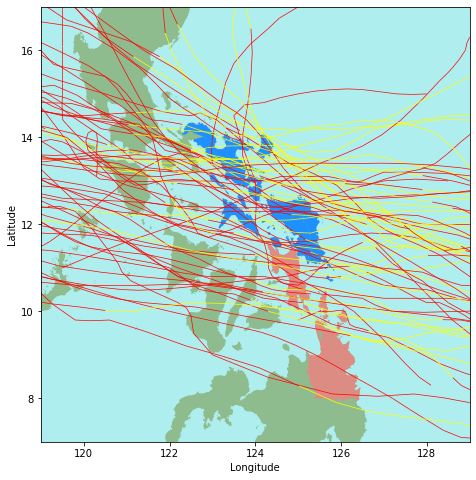

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('paleturquoise')

gdf.plot(ax=ax, color='darkseagreen')
gdf_s1.plot(ax=ax, color='dodgerblue')
gdf_s2.plot(ax=ax, color='lightcoral', alpha=0.8)

for tc in tc_tracks_par_wind_intersect:
    wind = tc['max_sustained_wind'].values * 1.852
    # Get points for colouring the line
    points = np.array([tc.lon, tc.lat]).transpose().reshape(-1, 1, 2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=plt.get_cmap('autumn'), lw=0.7)
    lc.set_array(wind)
    lc.set_clim(vmin=180, vmax=181)
    ax.add_collection(lc)
ax.set_xlim(119, 129)
ax.set_ylim(7, 17)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")